# Notebook 1: Generating the XenoSignal Initial Dataset

Build the initial XenoSignal dataset from CellChat ligand–receptor interactions. We start with same-species pairs (mouse-only, human-only), expand them to cross-species directions (mouse→human, human→mouse) using ortholog mapping, resolve protein identifiers/sequences, and package job manifests for AlphaFold3.

**Inputs**

* `./Data/cellchat_data/` (CellChat LR interactions)
* `./Data/orthologs/` (ortholog mapping tables)

**Output**

* `./xenosignal_jobs.zip`

## Outline

1. **Generate Using Ortholog**
   Expand CellChat interactions to cross-species pairs via gene orthologs; keep directionality and record mapping provenance.
2. **Convert to Proteins**
   Map genes to protein IDs (e.g., UniProt/Ensembl) and sequences; validate and deduplicate ligand–receptor protein pairs.
3. **Prepare for AlphaFold3**
   Assemble per-pair job specs (metadata + sequences), organize run folders, and archive everything into `xenosignal_jobs.zip` for submission.


## 1. Generate Using Ortholog

In [1]:
import os
import pandas as pd
import numpy as np

# Function to apply the conversion
def convert_value(value, conversion_dict):
    if pd.isna(value):  # Ignore NaN values
        return np.nan
    return conversion_dict.get(value, [value])  # If value in dict, return list, otherwise wrap it in a list

# Function to create complex and cofactor dictionaries from CSVs
def load_dict_from_csv(file_path):
    df = pd.read_csv(file_path, index_col=0)
    return {index: row.dropna().tolist() for index, row in df.iterrows()}

# Function to apply complex and cofactor lists for multiple columns
def apply_conversions(df, complex_dict, cofactor_dict):
        # Apply conversions for human data
    convert_columns = {
        'complex': ['ligand', 'receptor'],
        'cofactor': ['agonist', 'antagonist', 'co_A_receptor', 'co_I_receptor']
    }
    for col in convert_columns['complex']:
        df[f'{col}_list'] = df[col].apply(lambda x: convert_value(x, complex_dict))
    for col in convert_columns['cofactor']:
        df[f'{col}_list'] = df[col].apply(lambda x: convert_value(x, cofactor_dict))

# Base directory for data files
base_dir = "repos/CellChat/data"

# Load data and create human complex/cofactor dictionaries
human_complex_dict = load_dict_from_csv(os.path.join(base_dir, 'CellChatDB.human_complex.csv'))
human_cofactor_dict = load_dict_from_csv(os.path.join(base_dir, 'CellChatDB.human_cofactor.csv'))

# Load mouse complex/cofactor dictionaries
mouse_complex_dict = load_dict_from_csv(os.path.join(base_dir, 'CellChatDB.mouse_complex.csv'))
mouse_cofactor_dict = load_dict_from_csv(os.path.join(base_dir, 'CellChatDB.mouse_cofactor.csv'))

# Read human interaction data
human_df = pd.read_csv(os.path.join(base_dir, 'CellChatDB.human_interaction.csv'))
human_df['ligand_type'] = "GRCh38"
human_df['receptor_type'] = "GRCh38"


# Read mouse interaction data
mouse_df = pd.read_csv(os.path.join(base_dir, 'CellChatDB.mouse_interaction.csv'))
mouse_df['ligand_type'] = "mm10"
mouse_df['receptor_type'] = "mm10"

apply_conversions(human_df, human_complex_dict, human_cofactor_dict)
apply_conversions(mouse_df, mouse_complex_dict, mouse_cofactor_dict)

# Merge the human and mouse dataframes
merged_df = pd.concat([human_df, mouse_df])
# merged_df.to_csv("cell-cell-data/merged_interaction_v2024.csv", index=False)


In [ ]:
# Flatten all lists in both columns into a single list
all_items = sum(merged_df["ligand_list"], []) + sum(merged_df["receptor_list"], [])
unique_items = set(all_items)
num_unique_items = len(unique_items)
print(f"Number of unique genes: {num_unique_items}")

Number of unique genes: 2821


: 

In [ ]:
def get_niches_orthologs_map(orthologs_file, organism = 'mm'):
    orthologs_df = pd.read_csv(os.path.join(orthologs_file), index_col=0)
    if (organism == 'hg'):
        orthologs_dict = orthologs_df.set_index('symbol')['symbol_mouse'].to_dict()
    else:
        orthologs_dict = orthologs_df.set_index('symbol_mouse')['symbol'].to_dict()
    return orthologs_dict


def get_orthologs_map(orthologs_file, organism = 'mm'):
    # obj._code = {"human": 9606, "rat": 10116, "mouse": 10090}[value].
    # Another resource http://www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt
    # Downloading orthologs file if it does not exist:
    # orthologs_file = 'https://data.broadinstitute.org/gsea-msigdb/msigdb/annotations_versioned/Mouse_Gene_Symbol_Remapping_Human_Orthologs_MSigDB.v7.5.1.chip'

    # loading orthologs file:
    orthologs_df = pd.read_csv(os.path.join(orthologs_file), sep='\t', compression='infer', low_memory=False)
    orthologs_df.rename(columns={'Probe Set ID': 'Mm gene symbol', 'Gene Symbol': 'Hs gene symbol'}, inplace=True)
    orthologs_df.drop('Gene Title', axis=1, inplace=True)
    orthologs_df = orthologs_df.applymap(lambda s: s if type(s) == str else s)

    if (organism == 'hg'):
        orthologs_dict = orthologs_df.set_index('Hs gene symbol')['Mm gene symbol'].to_dict()
    else:
        orthologs_dict = orthologs_df.set_index('Mm gene symbol')['Hs gene symbol'].to_dict()
    return orthologs_dict


gene_mouse_dict_msig_db = get_orthologs_map(orthologs_file ="cell-cell-data/orthologs/Mouse_Gene_Symbol_Remapping_Human_Orthologs_MSigDB.v7.5.1.chip",organism ='mm') 
gene_mouse_dict_reverse_msig_db = {v: k for k, v in gene_mouse_dict_msig_db.items()}

gene_mouse_dict = get_niches_orthologs_map(orthologs_file ="cell-cell-data/orthologs/nichenet_info_human.csv",organism ='mm') 
gene_mouse_dict_reverse = get_niches_orthologs_map(orthologs_file ="cell-cell-data/orthologs/nichenet_info_human.csv",organism ='hg') 


print(len(gene_mouse_dict), len(gene_mouse_dict_reverse))
print(len(gene_mouse_dict_msig_db), len(gene_mouse_dict_reverse_msig_db))

count = 0
for key, value in gene_mouse_dict_msig_db.items():
    # If the key is not present in gene_mouse_dict, add it
    if key not in gene_mouse_dict:
        count+=1
        gene_mouse_dict[key] = value
print(count)

count = 0
for key, value in gene_mouse_dict_reverse_msig_db.items():
    # If the key is not present in gene_mouse_dict, add it
    if key not in gene_mouse_dict_reverse:
        count+=1
        gene_mouse_dict_reverse[key] = value
print(count)

### MISSING ORTHOLOGS

missing_orth_genes = pd.read_csv("cell-cell-data/orthologs/missing_ortho_genes.csv", index_col=0,header=None)[1].to_dict()

C:\Users\alyos\AppData\Local\Temp\ipykernel_29768\976647354.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  orthologs_df = orthologs_df.applymap(lambda s: s if type(s) == str else s)


18758 18308
101764 18323
83996
1455


In [23]:
# Function to convert genes based on type
def convert_gene(gene, conversion_dict):
    converted_gene = conversion_dict.get(gene, "")
    if(converted_gene == ""):
        converted_gene = missing_orth_genes[gene]
    return converted_gene

# Function to convert rows based on source_type and target_type
def replicate_and_convert(row, convert_type):
    new_row = row.copy()

    new_row[f'{convert_type}_list'] = [
        convert_gene(g, gene_mouse_dict_reverse) if row[f'{convert_type}_type'] == 'GRCh38' else convert_gene(g, gene_mouse_dict)
        for g in row[f'{convert_type}_list']
    ]
    new_row[f'{convert_type}_type'] = 'mm10' if row[f'{convert_type}_type'] == 'GRCh38' else 'GRCh38'

    return new_row


# Apply the conversion for ligands (source)
new_rows_1 = merged_df.apply(replicate_and_convert, axis=1, convert_type="ligand")
# Apply the conversion for receptors (target)
new_rows_2 = merged_df.apply(replicate_and_convert, axis=1, convert_type="receptor")
# Append new rows to the original dataframe
ortho_merged_df = pd.concat([merged_df, new_rows_1, new_rows_2], ignore_index=True)
# ortho_merged_df.to_csv("cell-cell-data/cellchat_interactions_ortho_v2024.csv", index=False)


In [26]:
len(ortho_merged_df)

19839

## 2. Convert to Protiens

In [29]:
import os
import pandas as pd
import ast  # To safely evaluate strings that represent lists

# Function to parse string to list, leaving NaN values unchanged
def parse_list_column(column):
    return column.apply(lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else x)


df_pairs = pd.read_csv(os.path.join("cell-cell-data", "cellchat_interactions_ortho_v2024.csv"))
for column in df_pairs.columns:
    if("list" in column):
        df_pairs[column] = parse_list_column(df_pairs[column] )


unique_genes = set()
for index, row in df_pairs.iterrows():
    for g in row["ligand_list"]:
        unique_genes.add((g, row["ligand_type"]))

    for g in row["receptor_list"]:
        unique_genes.add((g, row["receptor_type"]))

print(len(unique_genes))

2983


In [17]:
from Bio import Entrez, SeqIO
import tqdm
# Set your email to use Entrez
Entrez.email = "aly.abdelkareem1@ucalgary.ca"  # Replace with your email

# Dictionary to map species codes to scientific names
species_mapping = {
    "GRCh38": "Homo sapiens",
    "mm10": "Mus musculus"
}

def fetch_protein_sequence_from_formatted_gene(gene_name, species_code):
    """
    Fetch the protein sequence from NCBI based on a formatted gene name.

    Parameters:
        formatted_gene (str): Gene name in the format "<species_code>-<gene_name>", 
                              e.g., "GRCh38-TGFB1" for human TGFB1 gene,
                              "mm10-Angptl1" for mouse Angptl1 gene.

    Returns:
        str: The protein sequence if found; otherwise, an error message.
    """
    try:

        # Get the species name from the species code
        species_name = species_mapping.get(species_code)
        
        # Check if the species code is valid
        if not species_name: 
            return f"Unknown species code: {species_code}. Please use a valid code (e.g., 'GRCh38' or 'mm10')."
        
        # Construct the search query for NCBI
        query = f"{gene_name}[Gene Name] AND {species_name}[Organism]"
        
        # Search the protein database with the given gene name and species
        handle = Entrez.esearch(db="protein", term=query)
        record = Entrez.read(handle)
        handle.close()
        
        # If no results found, return a message
        if not record["IdList"]:
            print(f"No protein found for gene {gene_name} in {species_name}.")
            return None
        
        # Get the first protein ID
        protein_id = record["IdList"][0]
        
        # Fetch the protein sequence using the protein ID
        handle = Entrez.efetch(db="protein", id=protein_id, rettype="fasta", retmode="text")
        seq_record = SeqIO.read(handle, "fasta")
        handle.close()
        
        # Return the protein sequence
        return protein_id, seq_record
    
    except ValueError:
        print(f"Invalid input format. {gene_name}'.")
        return None
    except Exception as e:
        print(f"An error occurred: {gene_name}\t{str(e)}")
        return None

gene_portein_dict = {}
for gene, species_code in tqdm.tqdm(unique_genes):
    gene_portein_dict[gene] = fetch_protein_sequence_from_formatted_gene(gene, species_code)

  2%|▏         | 46/2983 [00:40<31:03,  1.58it/s]  

No protein found for gene Ccl3l1 in Mus musculus.


  2%|▏         | 51/2983 [00:44<31:17,  1.56it/s]

No protein found for gene Ccl15 in Mus musculus.


  4%|▍         | 112/2983 [01:40<33:48,  1.42it/s] 

No protein found for gene H2-T25 in Homo sapiens.


  4%|▍         | 119/2983 [01:47<41:55,  1.14it/s]

No protein found for gene H2-T27 in Homo sapiens.


  8%|▊         | 226/2983 [03:17<31:07,  1.48it/s]

No protein found for gene Klra11 in Mus musculus.


  8%|▊         | 233/2983 [03:22<28:19,  1.62it/s]

No protein found for gene Ccl21e in Homo sapiens.


  9%|▊         | 257/2983 [03:41<30:24,  1.49it/s]

No protein found for gene Sirpb1c in Homo sapiens.


  9%|▊         | 261/2983 [03:44<28:58,  1.57it/s]

No protein found for gene LOC230398 in Mus musculus.


 10%|▉         | 293/2983 [04:11<30:56,  1.45it/s]

No protein found for gene Il26 in Mus musculus.


 12%|█▏        | 354/2983 [05:03<28:23,  1.54it/s]

No protein found for gene Ceacam8 in Mus musculus.


 12%|█▏        | 355/2983 [05:04<24:31,  1.79it/s]

No protein found for gene LOC68165 in Mus musculus.


 13%|█▎        | 385/2983 [05:32<29:37,  1.46it/s]  

No protein found for gene Gm5868 in Mus musculus.


 14%|█▎        | 403/2983 [05:47<28:51,  1.49it/s]

No protein found for gene Prss3l in Homo sapiens.


 15%|█▍        | 433/2983 [06:11<26:11,  1.62it/s]

No protein found for gene H60b in Homo sapiens.


 15%|█▍        | 445/2983 [06:20<26:57,  1.57it/s]

No protein found for gene H2-T22 in Homo sapiens.


 15%|█▌        | 462/2983 [06:35<27:01,  1.55it/s]

No protein found for gene H2-T-ps in Mus musculus.


 16%|█▋        | 486/2983 [06:56<27:54,  1.49it/s]

No protein found for gene LOC230403 in Mus musculus.


 16%|█▋        | 489/2983 [06:57<24:45,  1.68it/s]

No protein found for gene LOC14599 in Mus musculus.


 17%|█▋        | 513/2983 [07:37<4:28:52,  6.53s/it]

An error occurred: Fas	Remote end closed connection without response


 18%|█▊        | 526/2983 [07:49<32:39,  1.25it/s]  

No protein found for gene Raet1b in Homo sapiens.


 19%|█▉        | 565/2983 [08:23<29:31,  1.37it/s]

No protein found for gene H60a in Homo sapiens.


 19%|█▉        | 571/2983 [08:28<28:16,  1.42it/s]

No protein found for gene H2-M11 in Homo sapiens.


 20%|██        | 599/2983 [08:53<29:10,  1.36it/s]

No protein found for gene Ceacam6 in Mus musculus.


 20%|██        | 602/2983 [08:55<26:37,  1.49it/s]

No protein found for gene LOC230396 in Mus musculus.


 22%|██▏       | 666/2983 [09:54<29:31,  1.31it/s]

No protein found for gene Gm15448 in Mus musculus.


 23%|██▎       | 697/2983 [10:23<35:13,  1.08it/s]

No protein found for gene H2-M9 in Homo sapiens.


 24%|██▎       | 708/2983 [10:32<25:53,  1.46it/s]

No protein found for gene LOC245615 in Mus musculus.


 27%|██▋       | 814/2983 [12:12<25:07,  1.44it/s]

No protein found for gene Adgre2 in Mus musculus.


 28%|██▊       | 841/2983 [12:37<25:30,  1.40it/s]

No protein found for gene H2-L in Homo sapiens.


 29%|██▉       | 879/2983 [13:15<40:16,  1.15s/it]

No protein found for gene Ncr3-ps in Mus musculus.


 33%|███▎      | 970/2983 [14:38<24:47,  1.35it/s]

No protein found for gene LOC545655 in Mus musculus.


 35%|███▍      | 1037/2983 [15:41<24:54,  1.30it/s]

No protein found for gene Fpr-rs6 in Homo sapiens.


 35%|███▌      | 1057/2983 [15:58<22:20,  1.44it/s]

No protein found for gene LOC242517 in Mus musculus.


 37%|███▋      | 1118/2983 [16:52<21:56,  1.42it/s]

No protein found for gene Htr1e in Mus musculus.


 38%|███▊      | 1137/2983 [17:09<22:37,  1.36it/s]

No protein found for gene LOC330122 in Mus musculus.


 39%|███▉      | 1160/2983 [17:29<21:50,  1.39it/s]

No protein found for gene Cd200r3 in Homo sapiens.


 39%|███▉      | 1170/2983 [17:37<22:06,  1.37it/s]

No protein found for gene Ccl14 in Mus musculus.


 40%|████      | 1195/2983 [17:59<21:48,  1.37it/s]

No protein found for gene H2-T24 in Homo sapiens.


 41%|████      | 1223/2983 [18:24<20:20,  1.44it/s]

No protein found for gene Ccl16 in Mus musculus.


 42%|████▏     | 1257/2983 [18:55<20:21,  1.41it/s]

No protein found for gene Htr3d in Mus musculus.


 43%|████▎     | 1281/2983 [19:17<20:18,  1.40it/s]

No protein found for gene H2-M10.2 in Homo sapiens.


 44%|████▎     | 1300/2983 [19:32<19:42,  1.42it/s]

No protein found for gene Gm21104 in Mus musculus.


 45%|████▍     | 1330/2983 [20:01<22:20,  1.23it/s]

No protein found for gene Trhr2 in Homo sapiens.


 45%|████▍     | 1333/2983 [20:03<18:56,  1.45it/s]

No protein found for gene H2-T18 in Homo sapiens.


 45%|████▌     | 1352/2983 [20:19<19:49,  1.37it/s]

No protein found for gene LOC242519 in Mus musculus.


 46%|████▌     | 1360/2983 [20:26<19:13,  1.41it/s]

No protein found for gene H2-Q9 in Homo sapiens.


 46%|████▋     | 1387/2983 [20:50<20:21,  1.31it/s]

No protein found for gene LOC215728 in Mus musculus.


 47%|████▋     | 1405/2983 [21:06<19:09,  1.37it/s]

No protein found for gene H2-T18 in Mus musculus.


 48%|████▊     | 1444/2983 [21:41<18:53,  1.36it/s]

No protein found for gene Cbr1b in Homo sapiens.


 49%|████▉     | 1474/2983 [22:08<18:34,  1.35it/s]

No protein found for gene H2-M1 in Homo sapiens.


 50%|████▉     | 1481/2983 [22:14<18:13,  1.37it/s]

No protein found for gene Pcdha4b in Homo sapiens.


 50%|████▉     | 1488/2983 [22:20<17:14,  1.44it/s]

No protein found for gene Ccl21d in Homo sapiens.


 51%|█████     | 1513/2983 [22:43<18:45,  1.31it/s]

No protein found for gene Cbr1b in Mus musculus.


 52%|█████▏    | 1542/2983 [23:08<18:02,  1.33it/s]

No protein found for gene Ulbp2 in Mus musculus.


 52%|█████▏    | 1551/2983 [23:16<16:02,  1.49it/s]

No protein found for gene Clec2b in Mus musculus.


 53%|█████▎    | 1567/2983 [23:30<17:58,  1.31it/s]

No protein found for gene Lilrb1 in Mus musculus.


 54%|█████▍    | 1611/2983 [24:12<17:03,  1.34it/s]

No protein found for gene H2-T9 in Homo sapiens.


 56%|█████▌    | 1660/2983 [24:58<19:39,  1.12it/s]

No protein found for gene Ccl21f in Homo sapiens.


 58%|█████▊    | 1721/2983 [25:53<16:01,  1.31it/s]

No protein found for gene mt-Rnr2 in Mus musculus.


 59%|█████▊    | 1750/2983 [26:20<14:37,  1.40it/s]

No protein found for gene Ccl21 in Mus musculus.


 59%|█████▉    | 1763/2983 [26:31<14:43,  1.38it/s]

No protein found for gene LOC100861969 in Mus musculus.


 61%|██████    | 1822/2983 [27:26<14:05,  1.37it/s]

No protein found for gene H2-T10 in Homo sapiens.


 63%|██████▎   | 1873/2983 [28:12<14:02,  1.32it/s]

No protein found for gene Gja6 in Homo sapiens.


 64%|██████▎   | 1896/2983 [28:33<12:44,  1.42it/s]

No protein found for gene OTTMUSG00000007662 in Mus musculus.


 66%|██████▌   | 1965/2983 [29:36<12:24,  1.37it/s]

No protein found for gene Il37 in Mus musculus.


 66%|██████▌   | 1972/2983 [29:43<12:21,  1.36it/s]

No protein found for gene H2-T26 in Homo sapiens.


 67%|██████▋   | 2007/2983 [30:14<11:38,  1.40it/s]

No protein found for gene H2-M10.5 in Homo sapiens.


 68%|██████▊   | 2025/2983 [30:31<11:40,  1.37it/s]

No protein found for gene LOC321021 in Mus musculus.


 68%|██████▊   | 2043/2983 [30:47<11:11,  1.40it/s]

No protein found for gene LOC15974 in Mus musculus.


 69%|██████▉   | 2059/2983 [31:02<11:22,  1.35it/s]

No protein found for gene Raet1g in Mus musculus.


 73%|███████▎  | 2170/2983 [32:46<09:37,  1.41it/s]

No protein found for gene Gm5678 in Mus musculus.


 73%|███████▎  | 2173/2983 [32:48<09:51,  1.37it/s]

No protein found for gene LOC15968 in Mus musculus.


 73%|███████▎  | 2188/2983 [33:02<10:49,  1.22it/s]

No protein found for gene Fpr-rs4 in Homo sapiens.


 74%|███████▎  | 2193/2983 [33:06<09:27,  1.39it/s]

No protein found for gene H2-D in Homo sapiens.


 74%|███████▍  | 2201/2983 [33:13<12:01,  1.08it/s]

No protein found for gene H2-M10.4 in Homo sapiens.


 75%|███████▍  | 2224/2983 [33:35<08:41,  1.46it/s]

No protein found for gene Gm5160 in Mus musculus.


 78%|███████▊  | 2316/2983 [34:58<08:23,  1.33it/s]

No protein found for gene LOC406211 in Mus musculus.


 79%|███████▉  | 2357/2983 [35:36<07:24,  1.41it/s]

No protein found for gene Sirpg in Mus musculus.


 81%|████████  | 2402/2983 [36:16<07:11,  1.35it/s]

No protein found for gene Htr3e in Mus musculus.


 81%|████████  | 2406/2983 [36:19<07:02,  1.37it/s]

No protein found for gene LOC638105 in Mus musculus.


 81%|████████  | 2410/2983 [36:23<07:42,  1.24it/s]

No protein found for gene H2-Q8 in Homo sapiens.


 83%|████████▎ | 2472/2983 [37:19<06:22,  1.34it/s]

No protein found for gene Lilrb2 in Mus musculus.


 85%|████████▌ | 2540/2983 [38:20<05:38,  1.31it/s]

No protein found for gene Fpr-rs3 in Homo sapiens.


 87%|████████▋ | 2600/2983 [39:16<05:08,  1.24it/s]

No protein found for gene Ccl18 in Mus musculus.


 88%|████████▊ | 2613/2983 [39:27<04:36,  1.34it/s]

No protein found for gene H2-M2 in Homo sapiens.


 89%|████████▉ | 2657/2983 [40:05<03:56,  1.38it/s]

No protein found for gene Pgr15l in Homo sapiens.


 91%|█████████ | 2712/2983 [40:56<03:26,  1.31it/s]

No protein found for gene LOC547343 in Mus musculus.


 92%|█████████▏| 2745/2983 [41:28<02:53,  1.37it/s]

No protein found for gene Klra in Homo sapiens.


 93%|█████████▎| 2767/2983 [41:48<02:34,  1.40it/s]

No protein found for gene H2-M10.6 in Homo sapiens.


 94%|█████████▍| 2806/2983 [42:23<02:06,  1.40it/s]

No protein found for gene Klra in Mus musculus.


 94%|█████████▍| 2812/2983 [42:29<02:29,  1.14it/s]

No protein found for gene Htr3c in Mus musculus.


 95%|█████████▍| 2824/2983 [42:39<01:50,  1.43it/s]

No protein found for gene H2-M10.3 in Homo sapiens.


 95%|█████████▌| 2840/2983 [42:54<01:46,  1.34it/s]

No protein found for gene H2-M5 in Homo sapiens.


 96%|█████████▌| 2849/2983 [43:02<01:48,  1.23it/s]

No protein found for gene Cxcl8 in Mus musculus.


 96%|█████████▋| 2873/2983 [43:24<01:21,  1.35it/s]

No protein found for gene Cd209f in Homo sapiens.


 97%|█████████▋| 2898/2983 [43:47<01:01,  1.39it/s]

No protein found for gene LOC15965 in Mus musculus.


 99%|█████████▊| 2942/2983 [44:30<00:30,  1.36it/s]

No protein found for gene Raet1l in Mus musculus.


100%|██████████| 2983/2983 [45:09<00:00,  1.10it/s]


In [34]:
# Create a list of rows for the DataFrame
data = []
for key, value in gene_portein_dict.items():
    if isinstance(value, tuple):  # Ensure it's a tuple of length 2
        identifier, record = value
        # Find the corresponding tuple from the unique_genes set
        gene_tuple = next(((gene_name, species) for gene_name, species in unique_genes if gene_name == key), (None, None))

        # Unpack gene_tuple safely
        gene_name = gene_tuple[0] if gene_tuple[0] is not None else ''
        species = gene_tuple[1] if gene_tuple[1] is not None else ''
        
        # Create the row with all relevant data
        row = {
            'Key': key,
            'Entrez_protein_id': identifier,
            'ID': record.id,
            'Sequence': str(record.seq),
            'Name': record.name,
            'Description': record.description,
            'DBxRefs': record.dbxrefs,
            'Gene Name': gene_name,  # First element from unique_genes tuple
            'Species': species        # Second element from unique_genes tuple
        }
        data.append(row)

df_proteins = pd.DataFrame(data)
df_proteins.to_csv("cell-cell-data/cellchat_proteins.csv")
df_proteins.head()


,Key,Entrez_protein_id,ID,Sequence,Name,Description,DBxRefs,Gene Name,Species
0,Fras1,126157515,NP_780682.3,MGVLKAWLGVALALAEFAVLPNCEGACLYQGSFLADATIWKPDSCQ...,NP_780682.3,NP_780682.3 extracellular matrix organizing pr...,[],Fras1,mm10
1,Ifna13,81871051,sp|Q80SU4.1|IFNAD_MOUSE,MARPCAFLMVLVVLSYWSACSLGCDLPQTHNLRNKRALTLLEQMRR...,sp|Q80SU4.1|IFNAD_MOUSE,sp|Q80SU4.1|IFNAD_MOUSE RecName: Full=Interfer...,[],Ifna13,mm10
2,Adgrl1,157739867,NP_851382.2,MARLAAALWSLCVTTVLVTSATQGLSRAGLPFGLMRRELACEGYPI...,NP_851382.2,NP_851382.2 adhesion G protein-coupled recepto...,[],Adgrl1,mm10
3,Erbb2,54873610,NP_001003817.1,MELAAWCRWGFLLALLSPGAAGTQVCTGTDMKLRLPASPETHLDML...,NP_001003817.1,NP_001003817.1 receptor tyrosine-protein kinas...,[],Erbb2,mm10
4,Lamb1,1666305206,NP_032508.3,MGLLQVFAFGVLALWGTRVCAQEPEFSYGCAEGSCYPATGDLLIGR...,NP_032508.3,NP_032508.3 laminin subunit beta-1 precursor [...,[],Lamb1,mm10


In [44]:
missing_protiens = set([x[0] for x in unique_genes]) - set(df_proteins["Key"].values) 
print(len(missing_protiens), missing_protiens)

60 {'H2-M10.3', 'Gm5160', 'Ceacam6', 'Gm15448', 'LOC638105', 'Gm5868', 'Raet1l', 'LOC15965', 'Gm5678', 'mt-Rnr2', 'LOC321021', 'Il37', 'LOC15974', 'Ccl3l1', 'Klra11', 'OTTMUSG00000007662', 'Htr3e', 'Ccl21d', 'LOC230396', 'Ceacam8', 'Adgre2', 'Ulbp2', 'H2-T9', 'LOC242519', 'Htr3d', 'Lilrb2', 'Ccl21', 'Ncr3-ps', 'LOC215728', 'LOC14599', 'Clec2b', 'Gm21104', 'LOC15968', 'Ccl14', 'Htr1e', 'Ccl18', 'Cbr1b', 'Cxcl8', 'LOC242517', 'LOC68165', 'LOC330122', 'Lilrb1', 'LOC100861969', 'Pcdha4b', 'LOC545655', 'LOC406211', 'H2-T-ps', 'Ccl15', 'Il26', 'Klra', 'Ccl16', 'LOC230403', 'H2-T18', 'Sirpg', 'Fas', 'Raet1g', 'LOC547343', 'LOC245615', 'Htr3c', 'LOC230398'}


In [81]:

gene_portein_dict = df_proteins.set_index('Key')["Sequence"].to_dict()
ortho_merged_df["found_protein"] = ortho_merged_df.apply(
    lambda row: not (any(gene in missing_protiens for gene in row['ligand_list']) or
                     any(gene in missing_protiens for gene in row['receptor_list'])),
    axis=1
)
ortho_merged_df["count_tokens"] = ortho_merged_df.apply(
    lambda row: sum(len(gene_portein_dict.get(gene, "")) for gene in row['ligand_list'] + row['receptor_list']),
    axis=1
)


<Axes: >

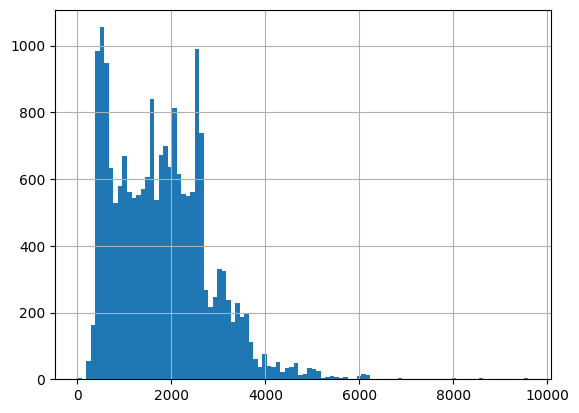

In [91]:
ortho_merged_df["count_tokens"].hist(bins=100)

In [88]:
### Select important pathways from paper 

paper_interactions1=pd.read_csv("cell-cell-data/varsha_cellchat/paper_interactions_1.csv")
paper_interactions2=pd.read_csv("cell-cell-data/varsha_cellchat/paper_interactions_2.csv")
paper_pathways = list(set(paper_interactions2['pathway_name'].unique().tolist() + paper_interactions1['pathway_name'].unique().tolist()))
paper_interactions1.head()

,source,target,source_target,Lspecies_Rspecies,ligand,receptor,prob,pval,interaction_name,ligand_2,receptor_2,pathway_name,annotation,evidence,ligand_species,receptor_species,interaction_name_2,lig_1k,recep1_1k,recep2_1k
0,D3,D3,D3_D3,Human_Human,GRCH38.AGRN,GRCH38.DAG1,0.000072,0.0,AGRN_DAG1,GRCH38.AGRN,GRCH38.DAG1,AGRN,ECM-Receptor,KEGG: hsa04512,Human,Human,GRCH38.AGRN - GRCH38.DAG1,h3,h2,NaN
1,D3,D3,D3_D3,Human_Human,GRCH38.AGRN,GRCH38.DAG1,0.000072,0.0,AGRN_DAG1,GRCH38.AGRN,GRCH38.DAG1,AGRN,ECM-Receptor,KEGG: hsa04512,Human,Human,GRCH38.AGRN - GRCH38.DAG1,h10,h3,NaN
2,D3,D3,D3_D3,Human_Human,GRCH38.AGRN,GRCH38.DAG1,0.000072,0.0,AGRN_DAG1,GRCH38.AGRN,GRCH38.DAG1,AGRN,ECM-Receptor,KEGG: hsa04512,Human,Human,GRCH38.AGRN - GRCH38.DAG1,NaN,h10,NaN
3,D3,D3,D3_D3,Human_Human,GRCH38.AGRN,GRCH38.DAG1,0.000072,0.0,AGRN_DAG1,GRCH38.AGRN,GRCH38.DAG1,AGRN,ECM-Receptor,KEGG: hsa04512,Human,Human,GRCH38.AGRN - GRCH38.DAG1,NaN,h11,NaN
4,D4,D4,D4_D4,Human_Human,GRCH38.AGRN,GRCH38.DAG1,0.001152,0.0,AGRN_DAG1,GRCH38.AGRN,GRCH38.DAG1,AGRN,ECM-Receptor,KEGG: hsa04512,Human,Human,GRCH38.AGRN - GRCH38.DAG1,h3,h2,NaN


In [114]:

ortho_merged_df['interaction_name'] = ortho_merged_df.apply(
        lambda row:f"{'_'.join(row['ligand_list']).upper()}_{'_'.join(row['receptor_list']).upper()}_{row['ligand_type']}_{row['receptor_type']}",
        axis=1
)

ortho_merged_df["selected_interaction"] = ortho_merged_df['pathway_name'].apply(lambda x: x in paper_pathways)
# Identify duplicates in the 'interaction_name' column
ortho_merged_df['is_duplicate'] = ortho_merged_df.duplicated(subset='interaction_name', keep=False)
# Create a column marking one of the duplicates to be removed (keeping only the first occurrence)
ortho_merged_df['to_remove'] = ortho_merged_df.duplicated(subset='interaction_name', keep='first')

ortho_merged_df = ortho_merged_df.sort_values(
    ['to_remove', 'pathway_name', 'selected_interaction'], 
    ascending=[True, False, False]
)


ortho_merged_df = ortho_merged_df.reset_index()     
ortho_merged_df["job_name"] = ortho_merged_df.apply(
        lambda row:f"Job{row.name}_{row['interaction_name']}",
        axis=1
)


ortho_merged_df = ortho_merged_df.drop(['index', 'Unnamed: 0'], axis=1)
ortho_merged_df.to_csv("cell-cell-data/cellchat_interactions_ortho_v2024.csv")

8859


## 3. Prepare for AlphaFold3

In [1]:
import os
import pandas as pd
import ast  # To safely evaluate strings that represent lists

# Function to parse string to list, leaving NaN values unchanged
def parse_list_column(column):
    return column.apply(lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else x)



df_proteins = pd.read_csv("cell-cell-data/cellchat_proteins.csv", index_col=0)
gene_portein_dict = df_proteins.set_index('Key')["Sequence"].to_dict()

ortho_merged_df = pd.read_csv("cell-cell-data/cellchat_interactions_ortho_v2024.csv", index_col=0)
for column in ortho_merged_df.columns:
    if("list" in column):
        ortho_merged_df[column] = parse_list_column(ortho_merged_df[column] )

ortho_merged_df.head()

C:\Users\alyos\AppData\Local\Temp\ipykernel_16964\1979898712.py:14: DtypeWarning: Columns (5,33) have mixed types. Specify dtype option on import or set low_memory=False.
  ortho_merged_df = pd.read_csv("cell-cell-data/cellchat_interactions_ortho_v2024.csv", index_col=0)


,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,...,agonist_list,antagonist_list,co_A_receptor_list,co_I_receptor_list,found_protein,count_tokens,job_name,selected_interaction,is_duplicate,to_remove
0,WNT11_FZD4_mm10_GRCh38,ncWNT,Wnt11,Fzd4,NaN,NaN,ncWNT activation receptor,NaN,KEGG: mmu04310,Secreted Signaling,...,NaN,NaN,"[Ryk, Ror2, Ror1]",NaN,True,722,Job0_WNT11_FZD4_mm10_GRCh38,True,True,False
1,WNT5B_FZD9_mm10_mm10,ncWNT,Wnt5b,Fzd9,NaN,NaN,ncWNT activation receptor,NaN,KEGG: mmu04310,Secreted Signaling,...,NaN,NaN,"[Ryk, Ror2, Ror1]",NaN,True,951,Job1_WNT5B_FZD9_mm10_mm10,True,False,False
2,WNT5B_FZD8_mm10_mm10,ncWNT,Wnt5b,Fzd8,NaN,NaN,ncWNT activation receptor,NaN,KEGG: mmu04310,Secreted Signaling,...,NaN,NaN,"[Ryk, Ror2, Ror1]",NaN,True,1044,Job2_WNT5B_FZD8_mm10_mm10,True,False,False
3,WNT5B_FZD7_mm10_mm10,ncWNT,Wnt5b,Fzd7,NaN,NaN,ncWNT activation receptor,NaN,KEGG: mmu04310,Secreted Signaling,...,NaN,NaN,"[Ryk, Ror2, Ror1]",NaN,True,931,Job3_WNT5B_FZD7_mm10_mm10,True,False,False
4,WNT5B_FZD6_mm10_mm10,ncWNT,Wnt5b,Fzd6,NaN,NaN,ncWNT activation receptor,NaN,KEGG: mmu04310,Secreted Signaling,...,NaN,NaN,"[Ryk, Ror2, Ror1]",NaN,True,1068,Job4_WNT5B_FZD6_mm10_mm10,True,False,False


In [2]:
len(ortho_merged_df), len(ortho_merged_df[ortho_merged_df["to_remove"] == False]), len(ortho_merged_df[(ortho_merged_df["to_remove"] == False)&(ortho_merged_df["selected_interaction"] == True) ])

(19839, 13546, 6053)

In [ ]:
def generate_json_from_df(df, gene_protein_dict, use_sito_info=False):
    job_list = []

    for _, row in df.iterrows():
        ligands = row['ligand_list']
        receptors = row['receptor_list']
        job_name = row['sito_job_name'] if use_sito_info else row['job_name']
        
        ligand_copy = row['sito_ligand'] if use_sito_info else 1
        receptor_copy = row['sito_receptor'] if use_sito_info else 1

        sequences = []

        for ligand in ligands:
            ligand_seq = gene_protein_dict.get(ligand, "")
            sequences.append({
                "proteinChain": {
                    "sequence": ligand_seq,
                    "count": int(ligand_copy)
                }
            })

        for receptor in receptors:
            receptor_seq = gene_protein_dict.get(receptor, "")
            sequences.append({
                "proteinChain": {
                    "sequence": receptor_seq,
                    "count": int(receptor_copy)
                }
            })

        job = {
            "name": job_name,
            "modelSeeds": [],
            "sequences": sequences
        }

        job_list.append(job)

    return job_list



subset_interactions_alphafold3 = ortho_merged_df[(ortho_merged_df["found_protein"]==True) &
                                                (ortho_merged_df["count_tokens"]<5000) &
                                                (ortho_merged_df["to_remove"] == False)]


In [4]:
ranges = [
(1,999999999)
]

# Filter based on job_name
def within_ranges(job_name, ranges):
    # Extract the numeric part from the job name
    try:
        job_id = int(job_name.split('_')[0][3:])  # Extract number after "Job"
        return any(start <= job_id <= end for start, end in ranges)
    except ValueError:
        return False

# Apply the filter
filtered_df = subset_interactions_alphafold3[
    subset_interactions_alphafold3["job_name"].apply(lambda x: within_ranges(x, ranges))
]

filtered_df["result_job_name"] = filtered_df['job_name'].apply(lambda x: x.lower().replace('-', '_'))


C:\Users\alyos\AppData\Local\Temp\ipykernel_16964\1667697679.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["result_job_name"] = filtered_df['job_name'].apply(lambda x: x.lower().replace('-', '_'))


In [5]:
len(filtered_df)


13282

In [6]:
results_files = []
results_dir = r'z:\xenosignaldb\alphafold_results'
for job_name in os.listdir(results_dir):
    results_files.append(job_name)

subset_df = filtered_df[
    ~filtered_df['result_job_name'].isin(results_files)
]

In [7]:
subset_df = subset_df[~subset_df.index.isin(range(4446, 5098))]


In [9]:

jobs_list = generate_json_from_df(subset_df, gene_portein_dict)

In [10]:
import os
import json

def save_chunks_to_json(data_list, dir_name, chunk_size=100):
    # Create directory if it doesn't exist
    os.makedirs(dir_name, exist_ok=True)

    # Chunk the data
    for i in range(0, len(data_list), chunk_size):
        chunk = data_list[i:i + chunk_size]
        file_name = os.path.join(dir_name, f'chunk_{i // chunk_size + 1}.json')

        # Save the chunk to a JSON file
        with open(file_name, 'w') as json_file:
            json.dump(chunk, json_file, indent=4)

save_chunks_to_json(jobs_list, 'output_interactions_last_chunk', chunk_size=20)